In [1]:
# import
import os, sys, csv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import brain_scatter_plot
from snaplab_tools.plotting.utils import get_my_colors
from snaplab_tools.utils import get_schaefer_system_mask

# Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data/int_deflections'
which_data = 'HCPYA'

outdir = '/home/lindenmp/research_projects/nct_xr/results/int_deflections/{0}'.format(which_data)

atlas = 'Schaefer4007'

if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

In [3]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
parc_centroids.drop(columns=['ROI Label'], inplace=True)
parc_centroids.head()

,R,A,S
ROI Name,,,
7Networks_LH_Vis_1,-33,-42,-21
7Networks_LH_Vis_2,-30,-33,-18
7Networks_LH_Vis_3,-36,-62,-17
7Networks_LH_Vis_4,-24,-55,-8
7Networks_LH_Vis_5,-23,-73,-10


In [4]:
# load rsfMRI clusters
in_file = '{0}_{1}_states.npy'.format(which_data, atlas)
states = np.load(os.path.join(outdir, in_file))
in_file = '{0}_{1}_states_labels.txt'.format(which_data, atlas)
states_labels = list(np.loadtxt(os.path.join(outdir, in_file), dtype=str, delimiter=','))

n_states = states.shape[0]
print('n_states, {0}'.format(n_states))
print(states_labels)

n_states, 20
['zeros', 'rest_1', 'rest_2', 'rest_3', 'rest_4', 'rest_5', 'rest_6', 'rest_7', 'tfMRI_EMOTION_LR_fear', 'tfMRI_EMOTION_LR_neut', 'tfMRI_GAMBLING_LR_win', 'tfMRI_GAMBLING_LR_loss', 'tfMRI_LANGUAGE_LR_math', 'tfMRI_LANGUAGE_LR_story', 'tfMRI_RELATIONAL_LR_match', 'tfMRI_RELATIONAL_LR_relation', 'tfMRI_SOCIAL_LR_mental', 'tfMRI_SOCIAL_LR_rnd', 'tfMRI_WM_LR_0bk', 'tfMRI_WM_LR_2bk']


# Plots

### Brain states: scatter

zeros


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


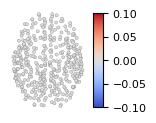

rest_1


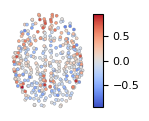

rest_2


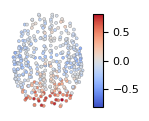

rest_3


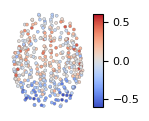

rest_4


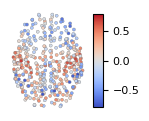

rest_5


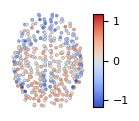

rest_6


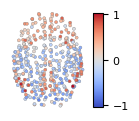

rest_7


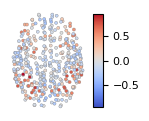

tfMRI_EMOTION_LR_fear


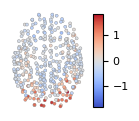

tfMRI_EMOTION_LR_neut


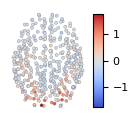

tfMRI_GAMBLING_LR_win


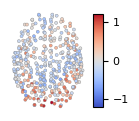

tfMRI_GAMBLING_LR_loss


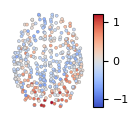

tfMRI_LANGUAGE_LR_math


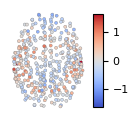

tfMRI_LANGUAGE_LR_story


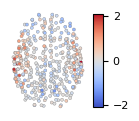

tfMRI_RELATIONAL_LR_match


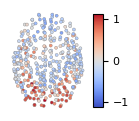

tfMRI_RELATIONAL_LR_relation


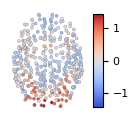

tfMRI_SOCIAL_LR_mental


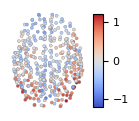

tfMRI_SOCIAL_LR_rnd


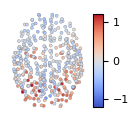

tfMRI_WM_LR_0bk


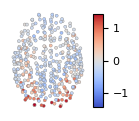

tfMRI_WM_LR_2bk


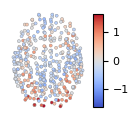

In [5]:
for state_idx in np.arange(n_states):
    print(states_labels[state_idx])
    f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=states[state_idx, :], cmap='coolwarm', add_colorbar=True) # vmin=-.8, vmax=.8, 
    f.savefig(os.path.join(outdir, "{0}_scatter.png".format(states_labels[state_idx])), dpi=600, bbox_inches="tight", pad_inches=0.01)

### Brain states: correlations between states

/home/lindenmp/anaconda3/envs/nct_xr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


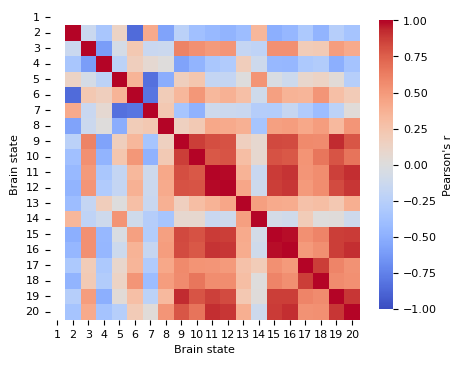

In [6]:
brain_state_corr = np.zeros((n_states, n_states))
for state_i in np.arange(n_states):
    for state_j in np.arange(n_states):
        nan_mask = np.logical_or(np.isnan(states[state_i, :]), np.isnan(states[state_j, :]))
        brain_state_corr[state_i, state_j] = sp.stats.pearsonr(states[state_i, ~nan_mask], states[state_j, ~nan_mask])[0]
        
f, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.heatmap(brain_state_corr, square=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar_kws={'shrink': 0.75, 'label': 'Pearson\'s r'})
ax.set_xlabel('Brain state')
ax.set_ylabel('Brain state')

x_tick_labels = []
for tick in ax.get_xticklabels():
    x_tick_labels.append(int(tick.get_text()) + 1)
ax.set_xticklabels(x_tick_labels, rotation=0)
y_tick_labels = []
for tick in ax.get_yticklabels():
    y_tick_labels.append(int(tick.get_text()) + 1)
ax.set_yticklabels(y_tick_labels, rotation=0)

f.savefig(os.path.join(outdir, "brain_state_correlation.svg".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

### Brain states: correspondence with canonical systems

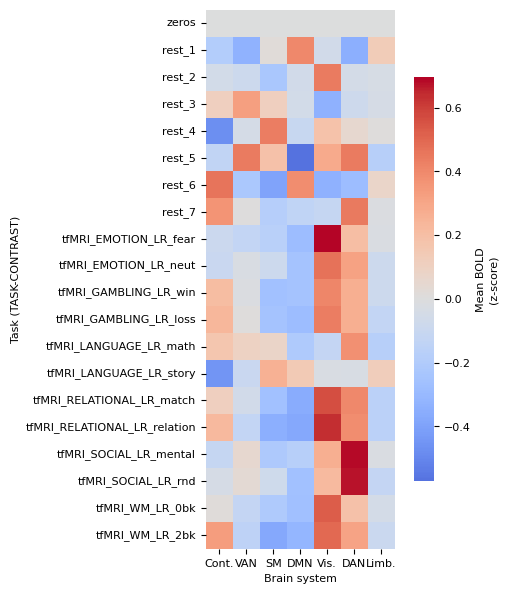

In [7]:
yeo_systems = ['Cont', 'SalVentAttn', 'SomMot', 'Default', 'Vis', 'DorsAttn', 'Limbic'] # k = 7
yeo_systems_labels = ['Cont.', 'VAN', 'SM', 'DMN', 'Vis.', 'DAN', 'Limb.'] # k = 7

n_systems = len(yeo_systems)
mean_activity = np.zeros((n_systems, n_states))
for system_idx in np.arange(n_systems):
    system_mask = get_schaefer_system_mask(parc_centroids.index, system=yeo_systems[system_idx])
    for state_idx in np.arange(n_states):
        mean_activity[system_idx, state_idx] = np.nanmean(states[state_idx, system_mask])

f, ax = plt.subplots(1, 1, figsize=(5, 7))

sns.heatmap(mean_activity.T, square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.75, 'label': 'Mean BOLD\n(z-score)'})
ax.set_ylabel('Task (TASK-CONTRAST)')
ax.set_xlabel('Brain system')

ax.set_yticklabels(states_labels, rotation=0)
ax.set_xticklabels(yeo_systems_labels, rotation=00)
f.savefig(os.path.join(outdir, "brain_state_system_mapping.svg".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)